# Gaussian Process Regression (GPR) Tutorial with scikit-learn
_A detailed walkthrough using the California Housing dataset_

Author: Shrey Nayak

---

## Objectives
- Understand **Gaussian Process Regression** theory.
- Learn how GPR models distributions over functions.
- Implement GPR in scikit-learn with different kernels.
- Compare GPR with a baseline regression model.
- Tune hyperparameters for better performance.


## 1. Introduction to Gaussian Process Regression

**Gaussian Process Regression (GPR)** is a **non-parametric, Bayesian** approach to regression.  
Instead of predicting a single value for each point, GPR predicts a **distribution** (mean + uncertainty) for each input.

---

### 2. Intuition
- A Gaussian Process defines a **distribution over functions**:
$$
f(x) \sim GP(m(x), k(x, x'))
$$
- \( m(x) \) is the mean function (often assumed 0).
- \( k(x, x') \) is the covariance function (kernel) that encodes similarity.

---

### 3. How it Works
1. Start with a prior belief about the function (mean, covariance).
2. Observe training data.
3. Update belief to get the **posterior distribution** of functions.
4. Make predictions — get both **mean** and **variance**.

---

### 4. Common Kernels
- **RBF (Radial Basis Function)**: Smooth, infinitely differentiable functions.
- **Matern**: Less smooth, more flexible.
- **DotProduct**: Linear trends.
- **WhiteKernel**: Models noise.

---

### 5. Advantages
- Provides **uncertainty estimates**.
- Works well with small datasets.
- Flexible through kernel choice.

### 6. Limitations
- **O(n³)** complexity → slow for large datasets.
- Kernel choice & hyperparameters greatly affect performance.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, ConstantKernel as C
from sklearn.linear_model import Ridge


In [2]:
# Load California Housing dataset
california = fetch_california_housing(as_frame=True)
df = california.frame

# For GPR speed, sample only 2000 points
df_sample = df.sample(2000, random_state=42)

# Features and target
X = df_sample.drop(columns=['MedHouseVal'])
y = df_sample['MedHouseVal']

print("Sampled dataset shape:", X.shape)


Sampled dataset shape: (2000, 8)


In [3]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale (important for kernels like RBF)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [4]:
# Define RBF kernel with initial length scale
kernel = RBF(length_scale=1.0)

# Create GPR model
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.1, normalize_y=True, random_state=42)

# Fit model
gpr.fit(X_train_scaled, y_train)

# Predict
y_pred, y_std = gpr.predict(X_test_scaled, return_std=True)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"GPR (RBF) -> RMSE: {rmse:.3f}, R²: {r2:.3f}")
print("Learned kernel:", gpr.kernel_)


GPR (RBF) -> RMSE: 0.617, R²: 0.725
Learned kernel: RBF(length_scale=1.11)


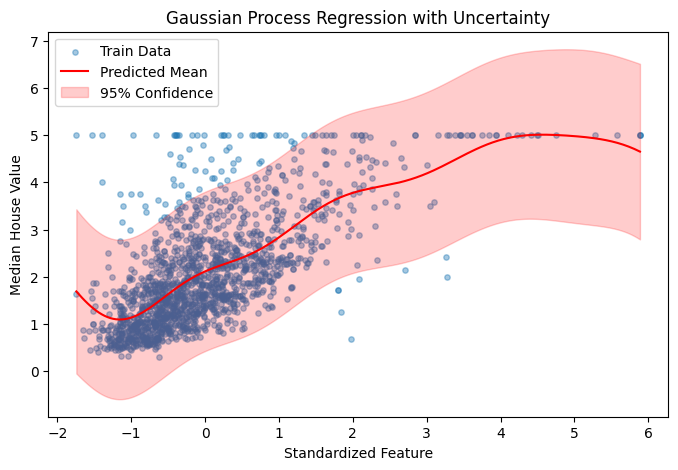

In [5]:
# Pick only 1 feature for plotting
feature_idx = 0
X_train_1d = X_train_scaled[:, feature_idx:feature_idx+1]
X_test_1d = X_test_scaled[:, feature_idx:feature_idx+1]

# Fit GPR on single feature for visualization
gpr_1d = GaussianProcessRegressor(kernel=RBF(length_scale=1.0) + WhiteKernel(), alpha=0.0, normalize_y=True)
gpr_1d.fit(X_train_1d, y_train)

# Predict
x_range = np.linspace(X_train_1d.min(), X_train_1d.max(), 200).reshape(-1, 1)
y_mean, y_std = gpr_1d.predict(x_range, return_std=True)

# Plot mean prediction and uncertainty band
plt.figure(figsize=(8,5))
plt.scatter(X_train_1d, y_train, s=15, alpha=0.4, label="Train Data")
plt.plot(x_range, y_mean, 'r', label="Predicted Mean")
plt.fill_between(x_range.ravel(), y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.2, color='r', label="95% Confidence")
plt.title("Gaussian Process Regression with Uncertainty")
plt.xlabel("Standardized Feature")
plt.ylabel("Median House Value")
plt.legend()
plt.show()


In [6]:
# More complex kernel: Constant * RBF + WhiteKernel (noise term)
kernel_custom = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) \
                + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))

gpr_custom = GaussianProcessRegressor(kernel=kernel_custom, normalize_y=True, random_state=42)
gpr_custom.fit(X_train_scaled, y_train)

y_pred_custom, _ = gpr_custom.predict(X_test_scaled, return_std=True)

print("Custom kernel learned:", gpr_custom.kernel_)
print("R² score:", r2_score(y_test, y_pred_custom))


Custom kernel learned: 1.29**2 * RBF(length_scale=1.71) + WhiteKernel(noise_level=0.194)
R² score: 0.7679622220308342


In [7]:
# Baseline Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

print(f"Ridge -> RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.3f}, R²: {r2_score(y_test, y_pred_ridge):.3f}")


Ridge -> RMSE: 0.711, R²: 0.635


## Conclusion

- Gaussian Process Regression models **a distribution over functions**, giving both mean predictions and uncertainty estimates.
- With the **RBF kernel**, GPR models smooth functions and adapts to non-linear trends.
- Kernel composition (e.g., `RBF + WhiteKernel`) allows modeling both trends and noise.
- For small datasets, GPR is powerful; for large datasets, it becomes computationally expensive.

**Advantages:**
- Probabilistic predictions with uncertainty.
- Flexible and expressive via kernels.
- Good for small-to-medium datasets.

**Disadvantages:**
- Slow for large datasets (O(n³) complexity).
- Sensitive to kernel choice and scaling.
- Requires careful hyperparameter tuning.

**Next Steps:**
- Try different kernels like `Matern` or `RationalQuadratic`.
- Use sparse approximations (`sklearn.gaussian_process.GaussianProcessRegressor` with `n_restarts_optimizer`).
- Apply to other regression problems with uncertainty needs.
